In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Graphs

- $\frac{dT}{dt} = T + h * T + a \cdot log(V) + b \cdot log(W) = h \cdot T + \log(V^a \cdot W^b)$
- $\frac{dW}{dt} = W$
- $\frac{dV}{dt} = a \cdot V +b \cdot e^{(-\frac{(T-T_0*d)^2}{c})}$

In [2]:
t_max = 50
t_min= 20
t_crit = 40
h = 0.1
W = 0.5
p = 0.1

In [3]:
data = pd.read_csv("../data/joined_T_W_V_P.csv")
data = data[data["WHO Country Name"] == "Germany"]
#data = data.pivot(columns=["variable"], values=["value"],index="city").reset_index()
#data.columns = ["city","PM2.5 (μg/m3)", "V", "T", "W"]
data = data.loc[:,["city","PM2.5 (μg/m3)", "V", "T", "W"]].groupby("city").mean()
data.columns = ["P", "V", "T", "W"]
data = data.dropna()

In [4]:
data

,P,V,T,W
city,,,,
Berlin,17.13500,906.291723,9.862667,1.261865e+09
Bremen,12.73250,1460.109486,10.002817,3.915588e+08
Dresden,14.98000,430.819578,9.114751,2.260791e+08
Frankfurt,20.75000,253.724771,10.466158,1.514076e+08
Hamburg,14.20750,2750.633633,9.656578,3.120128e+09
Leipzig,14.35875,304.171333,9.994178,1.948753e+08
Stuttgart,15.04375,346.676089,9.885315,1.691976e+07


## Vegetation vs Temp

In [5]:
# Steady state prediction linear
h, c, w = popt_linear
s, p = popt_lin
print("steady state temperature:", p/s)
print("steady state vegetation:", (h*p) / (c*s))

NameError: name 'popt_linear' is not defined

[ 0.57523869 -0.00080077]
[ 0.57523869 -0.00080077]


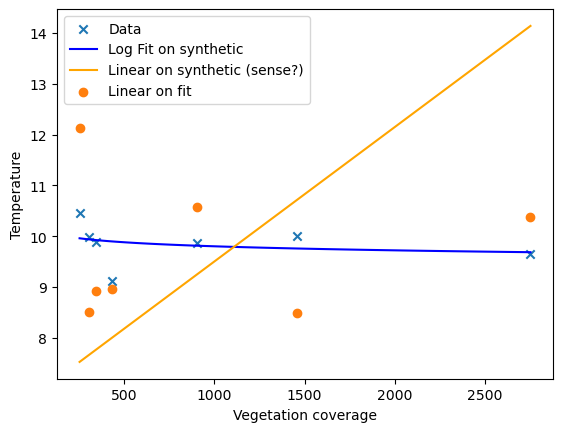

In [29]:
# Function candidates
def dt(V, h, a, b):
    T = data["T"].mean()
    W = data["W"].mean()
    return T + h * T + a * np.log(V) + b * np.log(W)

def dt_linear(VP , h, c):
    V, P = VP
    return  h*P - c *V

# Perform the curve fitting
popt, pcov = curve_fit(dt, data["V"], data["T"])
popt_linear, _ = curve_fit(dt_linear, (data["V"], data["P"]), data["T"])#,bounds=[[0,0,0],[100000,10000000,100000]],p0=[0,1,1])

print(popt_linear)
v_fit = np.linspace(min(data["V"]), max(data["V"]), 100)
p_fit = np.linspace(min(data["P"]), max(data["P"]), 100)
y_fit = dt(v_fit, *popt)
y_linear = dt_linear((v_fit, p_fit),  *popt_linear)

plt.scatter(data["V"],data["T"], marker = "x", label = "Data")
plt.plot(v_fit,y_fit, color = "blue", label = "Log Fit on synthetic")
plt.plot(v_fit,y_linear, color = "orange", label = "Linear on synthetic (sense?)")
plt.scatter(data["V"], dt_linear((data["V"],data["P"]),  *popt_linear), marker = "o", label = "Linear on fit")
plt.ylabel("Temperature")
plt.xlabel("Vegetation coverage")
plt.legend()
print(popt_linear)

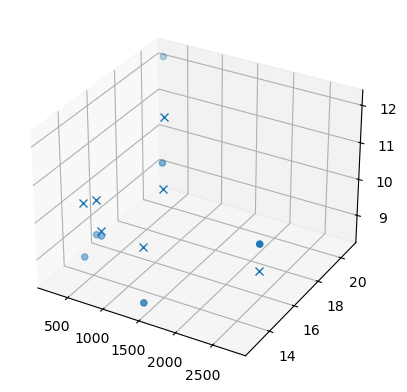

In [30]:
ax = plt.figure().add_subplot(projection='3d')
#ax.plot(v_fit, p_fit, dt_linear((v_fit, p_fit),  *popt_linear))
ax.plot(data["V"],data["P"], data["T"],"x")
ax.scatter(data["V"],data["P"], dt_linear((data["V"],data["P"]),  *popt_linear), marker = "o")

## Particulates VS Temperature & Vegetation

[ 0.09937015 -0.00022959]
[ 0.09937015 -0.00022959]


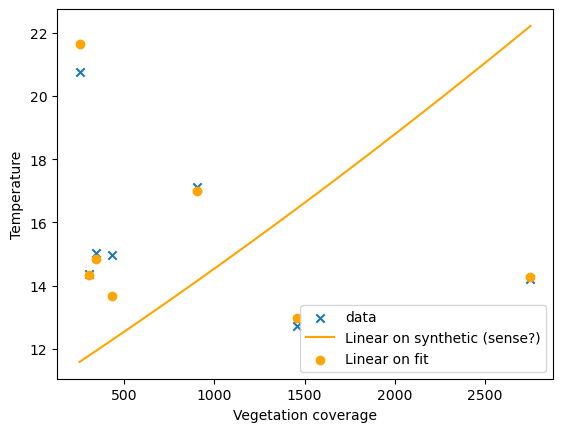

In [32]:
def dt_linear(PTV , p, r):
    P, T, V = PTV
    return  p * P * T - r * V

# Perform the curve fitting
popt_linear, _ = curve_fit(dt_linear, (data["P"], data["T"], data["V"]), data["P"])#,bounds=[[0,0,0],[100000,10000000,100000]],p0=[0,1,1])

print(popt_linear)
v_fit = np.linspace(min(data["V"]), max(data["V"]), 100)
t_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
p_fit = np.linspace(min(data["P"]), max(data["P"]), 100)

y_linear = dt_linear((p_fit, t_fit, v_fit),  *popt_linear)

plt.scatter(data["V"], data["P"], marker = "x", label = "data")
plt.plot(v_fit,y_linear, color = "orange", label = "Linear on synthetic (sense?)")
plt.scatter(data["V"], dt_linear((data["P"], data["T"], data["V"]),  *popt_linear), marker = "o",
        color = "orange", label = "Linear on fit")
plt.ylabel("Temperature")
plt.xlabel("Vegetation coverage")
plt.legend()
print(popt_linear)

## Water vs Temp

[ 4.93823918e+02 -7.12765564e+02 -4.63552030e-02]


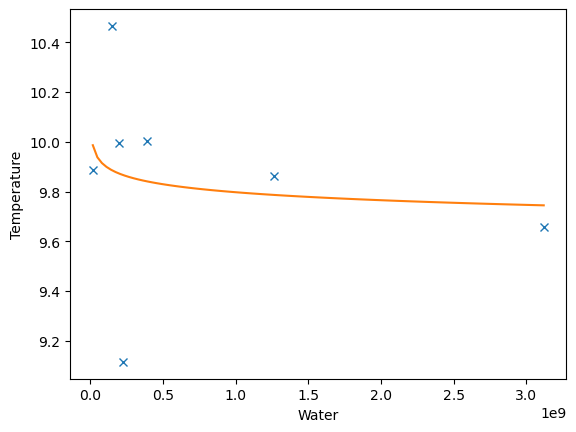

In [19]:
# Function candidates
def dt(W, h, a, b):
    T = data["T"].mean()
    V = data["V"].mean()
    return T + h * T + a * np.log(V) + b * np.log(W)

# Perform the curve fitting
popt, pcov = curve_fit(dt, data["W"], data["T"])

x_fit = np.linspace(min(data["W"]), max(data["W"]), 100)
y_fit = dt(x_fit, *popt)

plt.plot(data["W"],data["T"],"x")
plt.plot(x_fit,y_fit)
plt.ylabel("Temperature")
plt.xlabel("Water")
print(popt)

## Vegetation vs Temp

lin: [2575.0417389  -155.57534503   78.52907022]
log: [4.26355394e+00 8.98875969e+03]


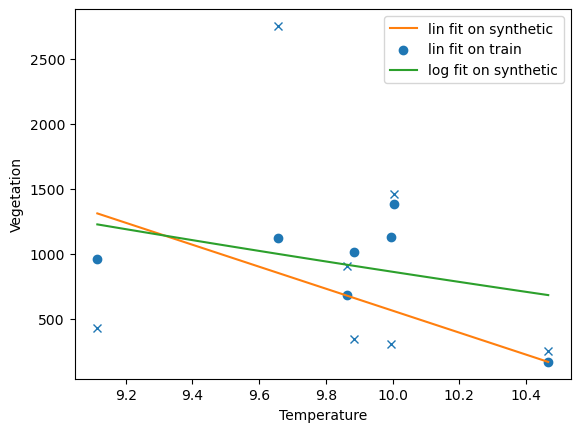

In [37]:
# Function candidates
def dV_lin(PT, s, g, a):
    P, T = PT
    return s+g*P + a*T

def dV_log(T, s, p):
    V = data["V"].mean()
    return V + p - s * np.log(T) * V

# Perform the curve fitting
popt_lin, pcov_lin = curve_fit(dV_lin, (data["P"], data["T"]), data["V"])
popt_log, pcov_log = curve_fit(dV_log, data["T"], data["V"])

t_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
p_fit = np.linspace(min(data["P"]), max(data["P"]), 100)
y_fit_lin = dV_lin((p_fit, t_fit), *popt_lin)
y_fit_log = dV_log(t_fit, *popt_log)

plt.plot(data["T"],data["V"],"x")
plt.plot(t_fit,y_fit_lin, label="lin fit on synthetic")
plt.scatter(data["T"],dV_lin((data["P"], data["T"]), *popt_lin), label="lin fit on train",
            marker="o")
plt.plot(t_fit,y_fit_log, label="log fit on synthetic")
plt.xlabel("Temperature")
plt.ylabel("Vegetation")
plt.legend(loc="best")
print("lin:",popt_lin)
print("log:",popt_log)

In [7]:
data

,city,V,T,W
0,Berlin,906.291723,9.862667,1.261865e+09
1,Bonn,86.508465,10.426283,7.134201e+07
2,Bremen,1460.109486,10.002817,3.915588e+08
3,Dresden,430.819578,9.114751,2.260791e+08
4,Frankfurt,253.724771,10.466158,1.514076e+08
5,Hamburg,2750.633633,9.656578,3.120128e+09
6,Köln,135.449316,10.670819,9.259949e+07
7,Leipzig,304.171333,9.994178,1.948753e+08
8,München,1601.137142,9.412584,2.351916e+09
9,Nürnberg,792.518412,9.380152,5.313243e+07


bell: [4.88491687e-01 2.61605977e+03 3.45681363e-02 9.69686654e-01]


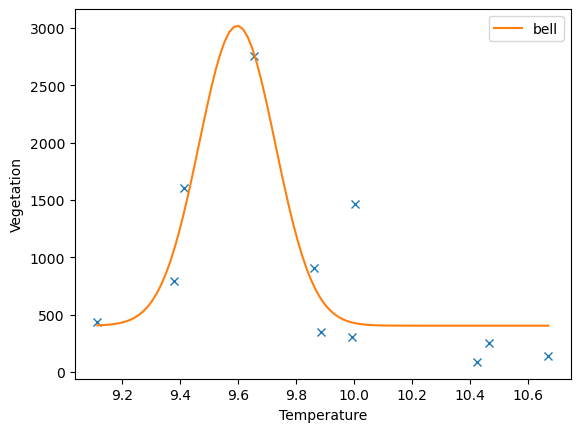

In [7]:
# Function candidates
def dV_bell(T, a, b, c, d):
    mean_temp = data["T"].mean()
    mean_v = data["V"].mean()
    return a*mean_v+b*np.exp(-((T - mean_temp*d)**2)/c)

# Perform the curve fitting
popt_bell, pcov_bell = curve_fit(dV_bell, data["T"], data["V"], bounds=([-np.inf,-np.inf, -np.inf, -1], [np.inf, np.inf, np.inf, 1]),
                                p0 =[1, 1000, 1, 1])

x_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
y_fit_bell = dV_bell(x_fit, *popt_bell)

plt.plot(data["T"],data["V"],"x")
plt.plot(x_fit,y_fit_bell, label="bell")
plt.xlabel("Temperature")
plt.ylabel("Vegetation")
plt.legend(loc="best")
print("bell:",popt_bell)